In [1]:
# Figure 1
# @author: Pelagia & Sushovan
# Created on 13th Oct, 2025

In [2]:
# 1. You need to install the following to get the required package for output

#!sudo apt-get install -y gmt gmt-dcw gmt-gshhg ghostscript
#!pip install pygmt geopandas shapely pyproj rtree fiona matplotlib

# 2. You also need the required shape file 


In [3]:
import pygmt
pygmt.show_versions()


PyGMT information:
  version: v0.13.0
System information:
  python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
  executable: /usr/bin/python3
  machine: Linux-6.8.0-85-generic-x86_64-with-glibc2.35
Dependency information:
  numpy: 1.26.4
  pandas: 2.2.2
  xarray: 2024.6.0
  netCDF4: 1.7.1.post1
  packaging: 24.1
  contextily: None
  geopandas: 1.0.1
  IPython: 8.26.0
  rioxarray: None
  gdal: None
  ghostscript: 9.55.0
GMT library information:
  version: 6.3.0
  padding: 2
  share dir: /usr/share/gmt
  plugin dir: /usr/lib/x86_64-linux-gnu/gmt/plugins
  library path: /usr/lib/x86_64-linux-gnu/libgmt.so
  cores: 12
  grid layout: rows
  image layout: 


In [4]:
import os
os.environ.setdefault("LD_LIBRARY_PATH", "/usr/lib/x86_64-linux-gnu:" + os.environ.get("LD_LIBRARY_PATH",""))
os.environ.setdefault("GMT_LIBRARY_PATH", "/usr/lib/x86_64-linux-gnu")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import geopandas as gpd
import pygmt
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
# verify GMT is accessible
pygmt.show_versions()


PyGMT information:
  version: v0.13.0
System information:
  python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
  executable: /usr/bin/python3
  machine: Linux-6.8.0-85-generic-x86_64-with-glibc2.35
Dependency information:
  numpy: 1.26.4
  pandas: 2.2.2
  xarray: 2024.6.0
  netCDF4: 1.7.1.post1
  packaging: 24.1
  contextily: None
  geopandas: 1.0.1
  IPython: 8.26.0
  rioxarray: None
  gdal: None
  ghostscript: 9.55.0
GMT library information:
  version: 6.3.0
  padding: 2
  share dir: /usr/share/gmt
  plugin dir: /usr/lib/x86_64-linux-gnu/gmt/plugins
  library path: /usr/lib/x86_64-linux-gnu/libgmt.so
  cores: 12
  grid layout: rows
  image layout: 


In [5]:
shapefile_path = "/home/sghos1/Desktop/coding_sprint/attiki_municipalities.shp"  # update path

gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Ensure 'KWD_YPES' is of type int
gdf['KWD_YPES'] = gdf['KWD_YPES'].astype(int)

print("Columns:", list(gdf.columns))
gdf.head()


Columns: ['fid', 'NAME', 'KWD_YPES', 'geometry']


,fid,NAME,KWD_YPES,geometry
0,8.0,Ilion,9182,"POLYGON ((23.68392 38.06429, 23.68763 38.06131..."
1,12.0,Agia Varbara,9179,"POLYGON ((23.64394 37.99855, 23.64396 37.99856..."
2,13.0,Agia Paraskevi,9167,"POLYGON ((23.84009 38.0241, 23.84021 38.02408,..."
3,15.0,Agios Dimitrios,9194,"POLYGON ((23.7413 37.94727, 23.74202 37.94095,..."
4,18.0,Agioi Anargyroi – Kamatero,9180,"POLYGON ((23.70441 38.06693, 23.71248 38.06623..."


In [6]:
# Normalize column names
gdf.columns = [c.strip() for c in gdf.columns]

# Ensure WGS84 CRS
if gdf.crs is None:
    gdf = gdf.set_crs(4326)
gdf = gdf.to_crs(4326)

# Sort by NAME safely
if "NAME" not in gdf.columns:
    raise KeyError(f"Expected 'NAME' column. Found: {list(gdf.columns)}")
gdf = gdf.sort_values("NAME").reset_index(drop=True)

# Assign IDs and compute centroid/representative point
gdf["ID"] = np.arange(1, len(gdf) + 1)
gdf = gdf.set_index("ID")

gdf_proj = gdf.to_crs(2100)
label_pts = gdf_proj.geometry.representative_point().to_crs(4326)
gdf["lon"], gdf["lat"] = label_pts.x, label_pts.y


text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.


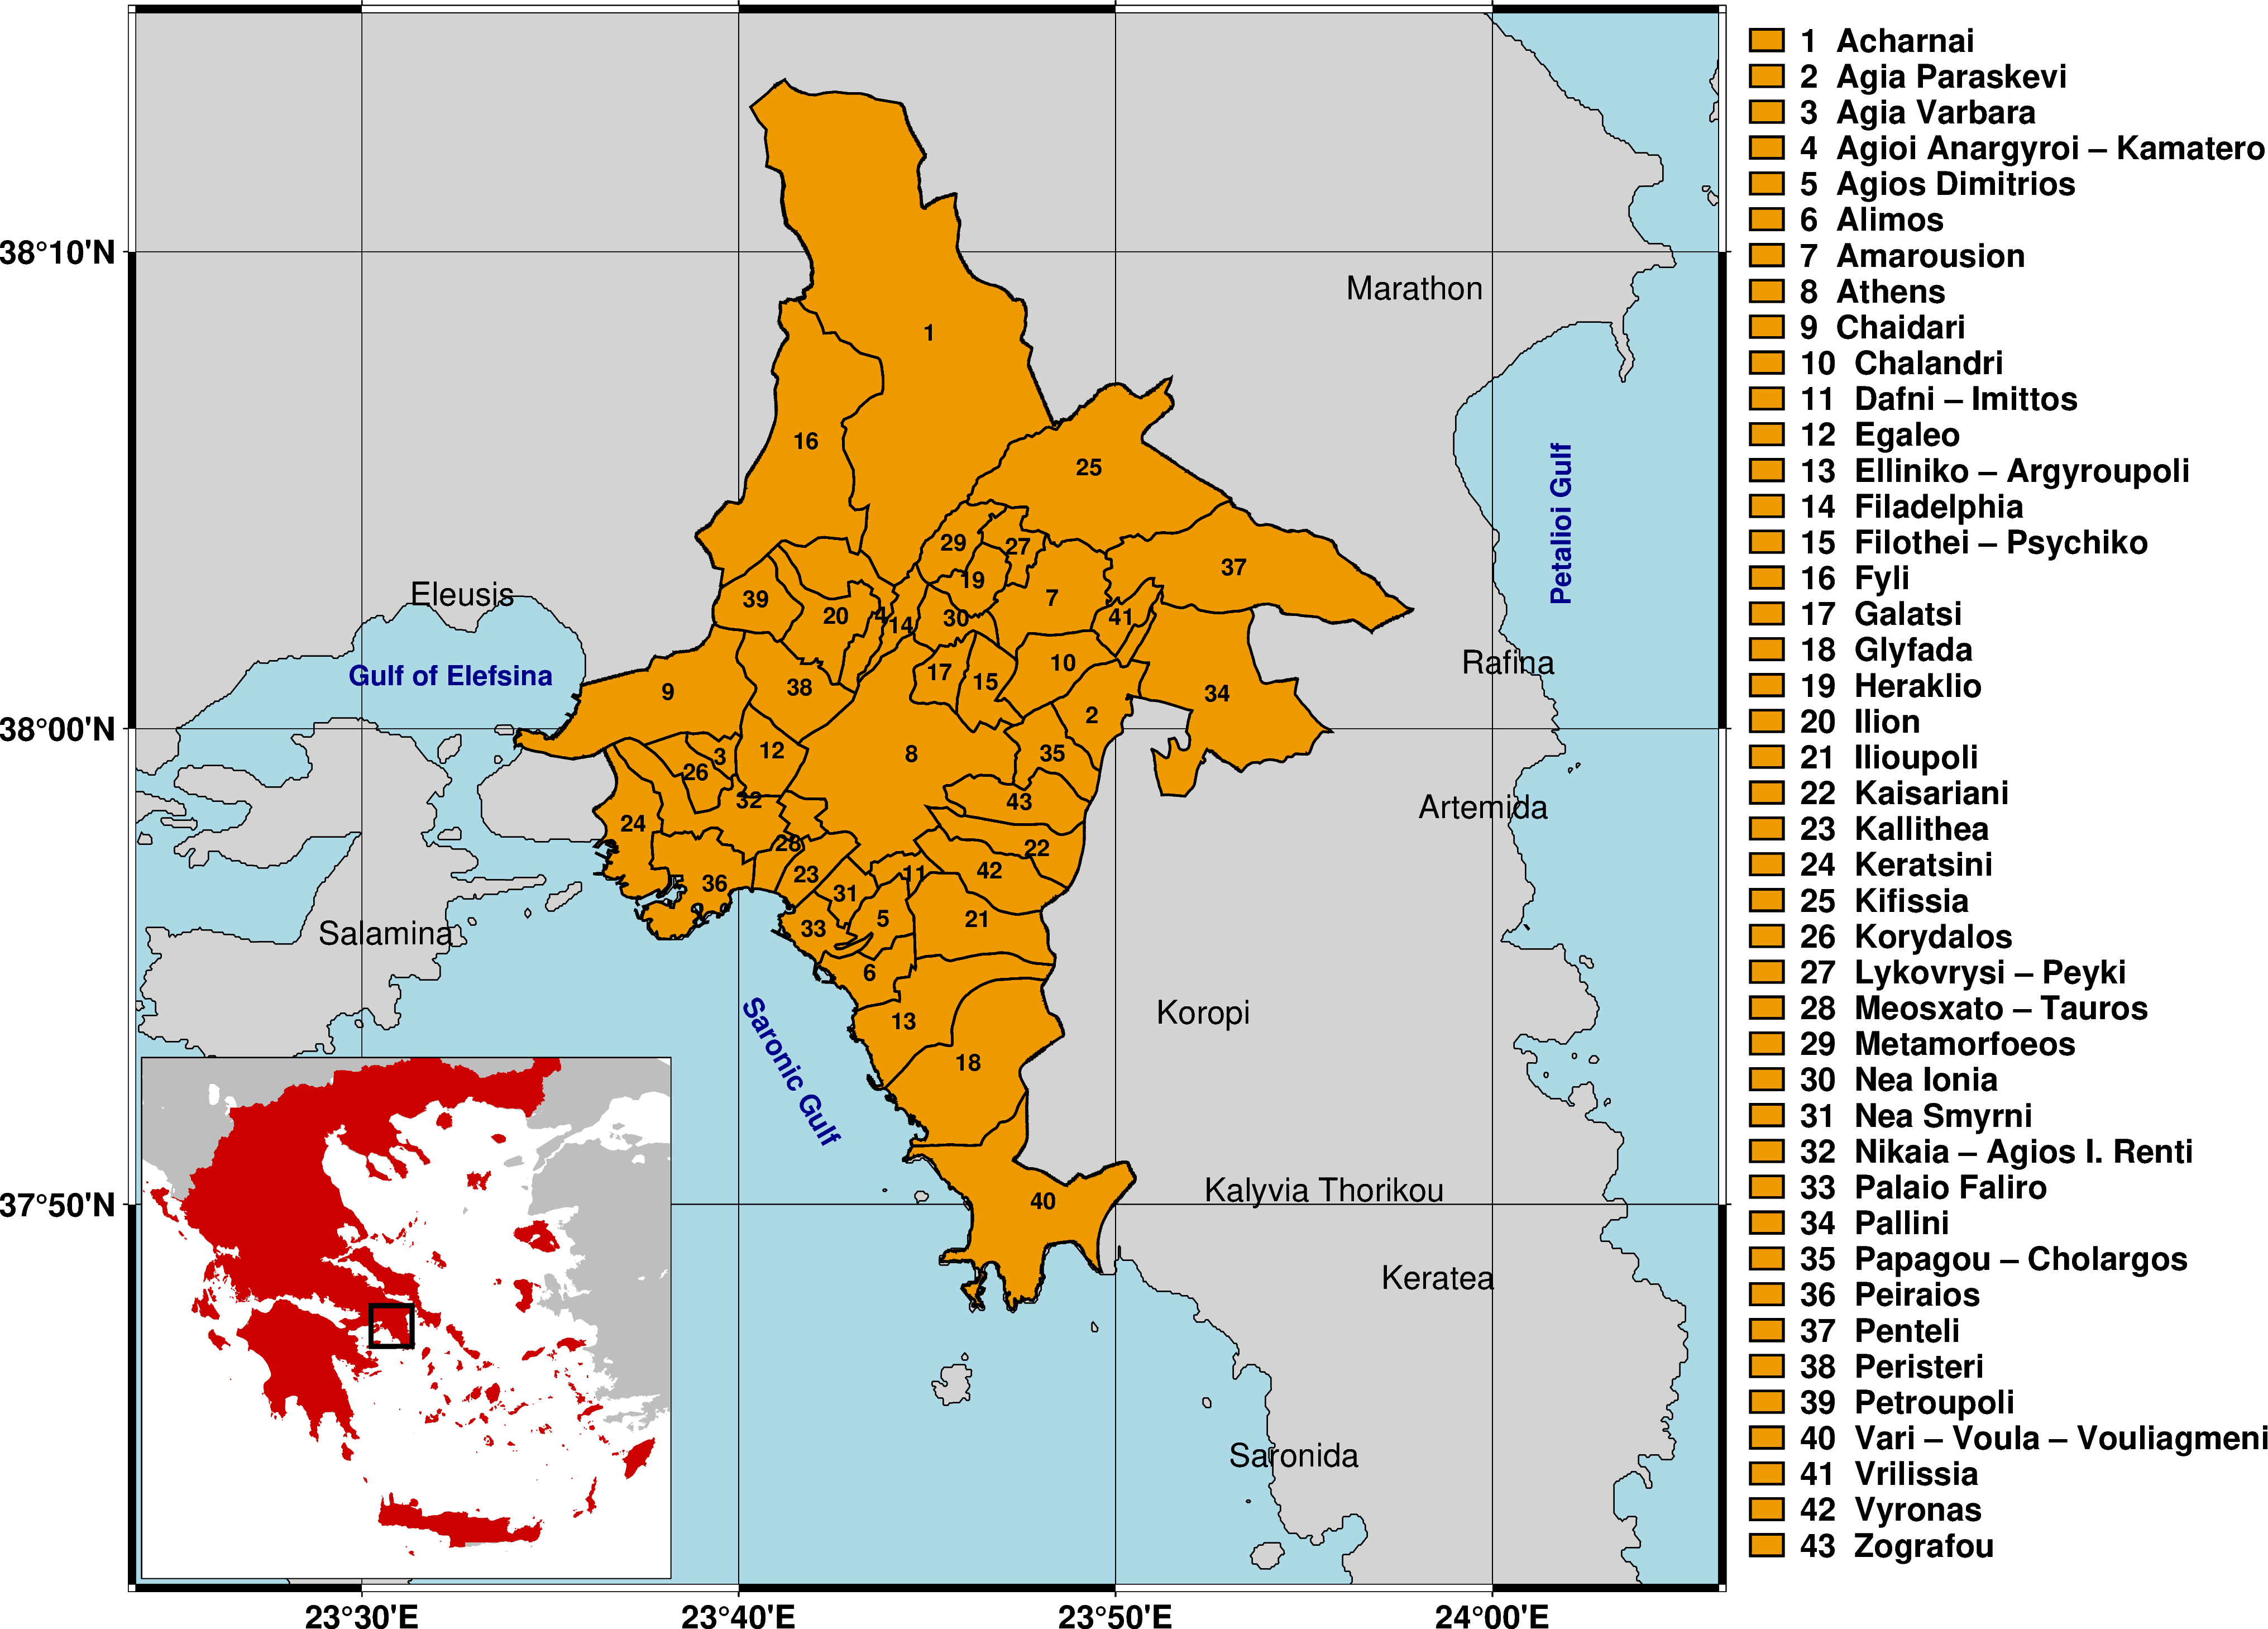

In [7]:
# --- Map region (Attica close-up) ---
region = [23.4, 24.1, 37.7, 38.25]  # [minlon, maxlon, minlat, maxlat]

# --- Figure & global config ---
fig = pygmt.Figure()
pygmt.config(FONT_ANNOT_PRIMARY="14p,Helvetica-Bold")

# Main Attica map
fig.coast(
    region=region,
    projection="M24c",
    land="lightgray",
    water="lightblue",
    borders="1/0.5p",
    shorelines="1/0.5p",
    frame="ag",
)

# Inset map (Greece + bounding box)
with fig.inset(
    position="jBL+o0.1c",
    margin=0,
    box="+p1p,black",
    projection="M8c",
    region=[19.5, 28.5, 34.5, 41.5],
):
    fig.coast(land="gray", water="white", dcw="GR+gred3")
    # draw rectangle of main region on inset
    rect = [[region[0], region[2], region[1], region[3]]]
    fig.plot(data=rect, style="r+s", pen="2p,black")

# Fill & outline each municipality; add legend entries as "ID  NAME"
for i in range(1, len(gdf) + 1):
    fig.plot(
        data=gdf[gdf.index == i],
        pen="1p,black",
        fill="orange2",
        label=f"{i}  {gdf.loc[i, 'NAME']}",
    )

# Numeric ID labels at representative points
for idx, row in gdf.iterrows():
    fig.text(
        x=row["lon"],
        y=row["lat"],
        text=str(idx),
        font="10p,Helvetica-Bold,black",
        justify="CM",
    )

# --- Extra place names on land ---
land_text_dict = {
    "Rafina": (38.023396, 24.006943),
    "Keratea": (37.807905, 23.976022),
    "Salamina": (37.928783, 23.510607),
    "Saronida": (37.745505, 23.912300),
    "Eleusis": (38.047254, 23.544445),
    "Marathon": (38.154147, 23.965705),
    "Artemida": (37.972771, 23.995991),
    "Koropi": (37.900835, 23.872206),
    "Kalyvia Thorikou": (37.838686, 23.925802),
}

for name, (lat, lon) in land_text_dict.items():
    fig.text(
        x=lon,
        y=lat,
        text=name,
        font="14p,Helvetica,black",
        justify="CM",
    )

# --- Water body names (with italics and angles) ---
water_text_dict = {
    "Saronic Gulf": (37.88, 23.69),
    "Gulf of Elefsina": (38.018846, 23.539217),
    "Petalioi Gulf": (38.071618, 24.029936),
}

fig.text(
    x=water_text_dict["Gulf of Elefsina"][1],
    y=water_text_dict["Gulf of Elefsina"][0],
    text="Gulf of Elefsina",
    font="12p,Helvetica-Italic,blue4",
    justify="CM",
)

fig.text(
    x=water_text_dict["Saronic Gulf"][1],
    y=water_text_dict["Saronic Gulf"][0],
    text="Saronic Gulf",
    font="12p,Helvetica-Italic,blue4",
    angle=300,
    justify="CM",
)

fig.text(
    x=water_text_dict["Petalioi Gulf"][1],
    y=water_text_dict["Petalioi Gulf"][0],
    text="Petalioi Gulf",
    font="12p,Helvetica-Italic,blue4",
    angle=90,
    justify="CM",
)

# Legend (lists "ID  Municipality")
fig.legend(position="jTR+o-8.5c/0c")

fig.show()